# Tech Challenge 02 - Prevendo dados da Bolsa

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA para criar uma série temporal e prever diariamente o fechamento da base.

Para isso, utilize a base de dados contida no site da investing e selecione o período "diário", com o intervalo de tempo que achar adequado.

Você precisará demonstrar para o time de investimentos:

* o modelo com o storytelling, desde a captura do dado até a entrega do modelo
* justificar a técnica utilizada
* atingir uma acuracidade adequada (acima de 70%)

### 01 - Importando bibliotecas

In [629]:
# Bibliotecas básicas de data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

# Para baixar os dados
import yfinance as yf

#Para aplicar o ARIMA:
from statsmodels.tsa.stattools import adfuller          
from statsmodels.tsa.stattools import acf, pacf       
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.arima.model import ARIMA           
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Encontrando os Picos de Sazonalidade
from scipy.signal import find_peaks

# Para deep learning
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError
from keras.models import load_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Para machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')
import logging
logging.disable(logging.CRITICAL)

# Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation,performance_metrics



#### 01.1 - Fazendo Upload dos dados

In [630]:
import yfinance as yf

# Especifique o símbolo da IBOVESPA (^BVSP) e o intervalo de datas desejado
symbol = '^BVSP'
start_date = '2015-01-01'
end_date = '2024-01-19'

# Use a função download para obter os dados
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [631]:
df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,50005.0,50005.0,48345.0,48512.0,48512.0,2882100
1,2015-01-05,48512.0,48512.0,47264.0,47517.0,47517.0,3866100
2,2015-01-06,47517.0,48061.0,47338.0,48001.0,48001.0,4559300
3,2015-01-07,48006.0,49882.0,48006.0,49463.0,49463.0,4408800
4,2015-01-08,49463.0,50261.0,49017.0,49943.0,49943.0,3621900


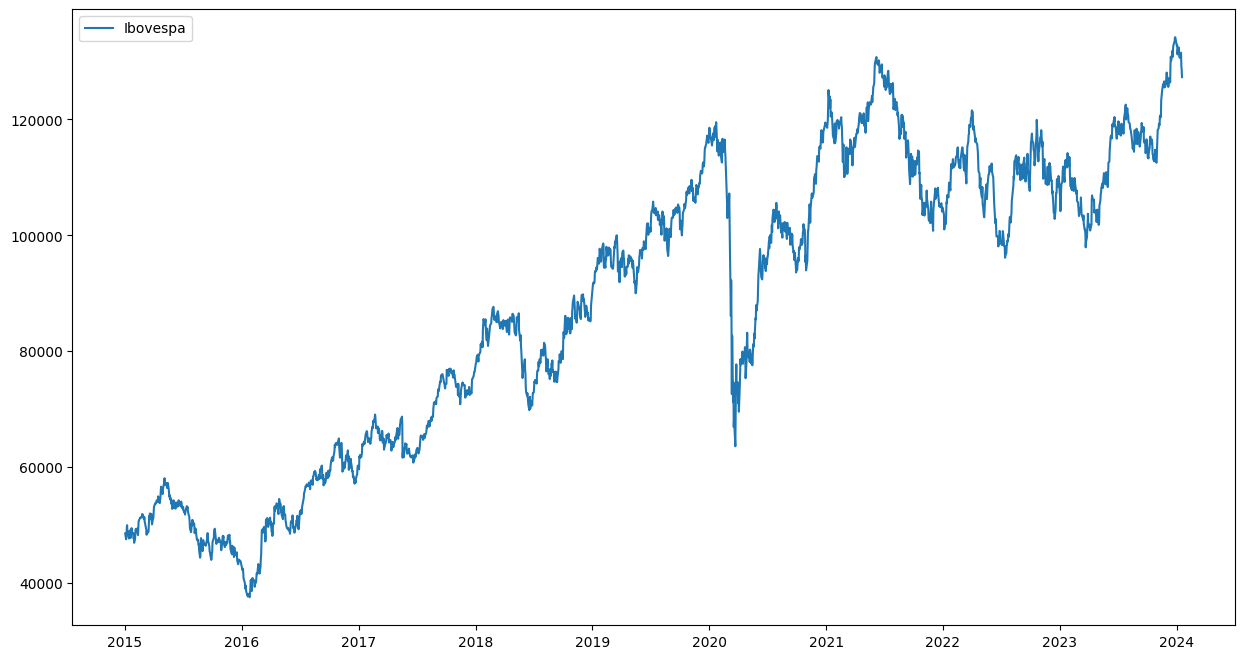

In [632]:
plt.figure(figsize = (15,8))
plt.plot(df['Date'], df['Close'], label='Ibovespa')

plt.legend(loc='best')
plt.show()

#### 01.2 - Analisando a Decomposição da Série Temporal

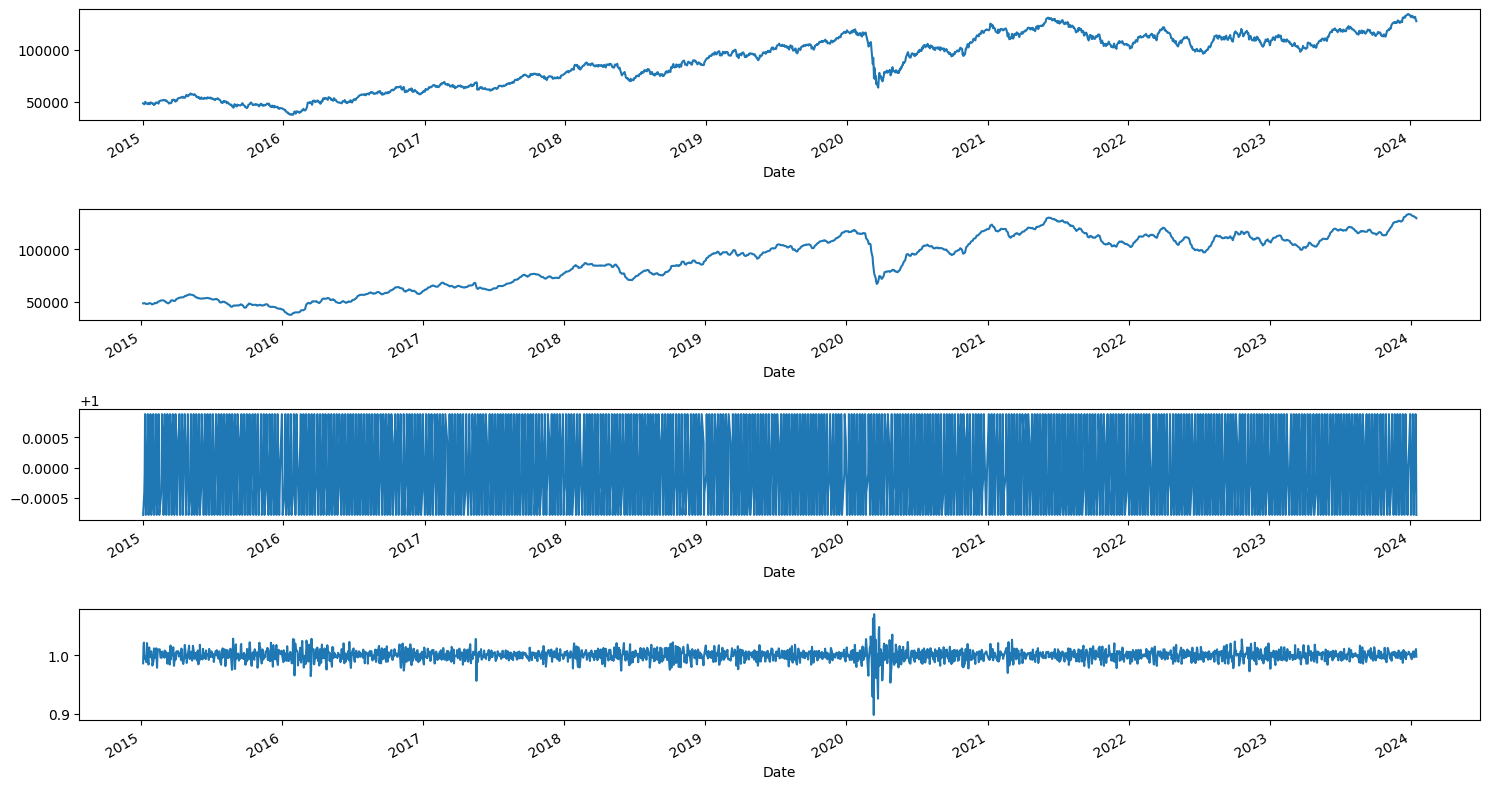

In [633]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

df_limpo = df                                                              
df_limpo['Date'] = pd.to_datetime(df_limpo['Date'])                        
df_limpo = df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close']) 
df_limpo = df_limpo.set_index('Date')                                      

seasonplot = seasonal_decompose(df_limpo, model='multiplicative', period=5) 
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1) 
seasonplot.trend.plot(ax=ax2)    
seasonplot.seasonal.plot(ax=ax3) 
seasonplot.resid.plot(ax=ax4)    
plt.tight_layout()

### 02 - Testando Modelos

#### 02.1 - Trabalhando com Estacionáridade (M.M.A., ARIMA E SARIMA)

#### 02.1.1 - Média Móvel com janela de prévisão de 10 dias e 20 dias

In [634]:
df = pd.DataFrame(df[['Close', 'Date']])
df.set_index('Date', inplace=True)
df['MA_window_10'] = df['Close'].rolling(10).mean().shift()
df['MA_window_20'] = df['Close'].rolling(20).mean().shift()

In [635]:
df.head(21)

,Close,MA_window_10,MA_window_20
Date,,,
2015-01-02,48512.0,NaN,NaN
2015-01-05,47517.0,NaN,NaN
2015-01-06,48001.0,NaN,NaN
2015-01-07,49463.0,NaN,NaN
2015-01-08,49943.0,NaN,NaN
2015-01-09,48840.0,NaN,NaN
2015-01-12,48140.0,NaN,NaN
2015-01-13,48042.0,NaN,NaN
2015-01-14,47646.0,NaN,NaN


##### Visualizando o resultado:

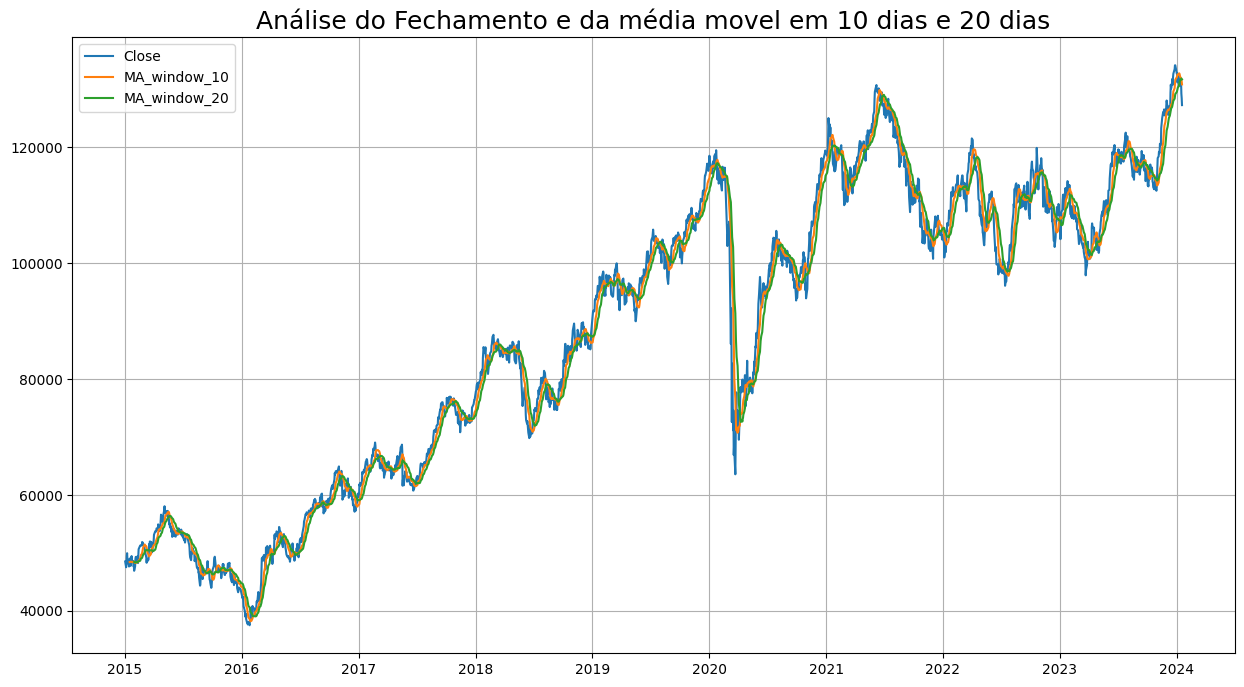

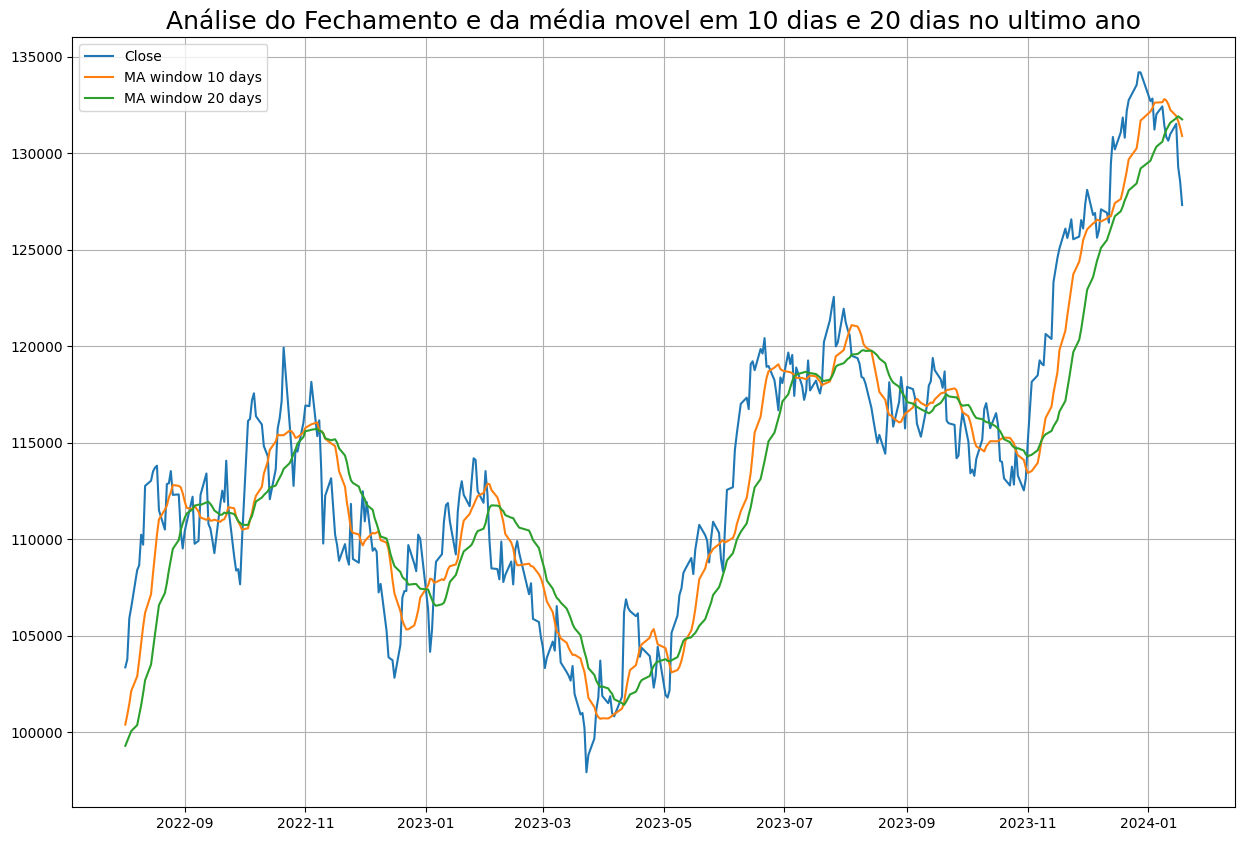

In [636]:
# Analisando todo o período com a média móvel
plt.figure(figsize=(15,8))
plt.grid(True)
plt.plot(df['Close'], label = 'Close')
plt.plot(df['MA_window_10'], label = 'MA_window_10')
plt.plot(df['MA_window_20'], label = 'MA_window_20')
plt.legend(loc=2)
plt.title(label = 'Análise do Fechamento e da média movel em 10 dias e 20 dias',
          loc='center',  fontsize=18)
plt.show()

# Destacando o período aos ultimo ano

limit = 365

plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['Close'][-limit:], label='Close')
plt.plot(df['MA_window_10'][-limit:], label='MA window 10 days')
plt.plot(df['MA_window_20'][-limit:], label='MA window 20 days')
plt.legend(loc=2)
plt.title(label = 'Análise do Fechamento e da média movel em 10 dias e 20 dias no ultimo ano',
          loc='center',  fontsize=18)
plt.show()




##### Prevendo "N" dias com base na MMA (Média Móvel Aritmética)

Nessa parte trabalharemos com a média movél de 10 dias e 20 dias, criando uma janela de tempo para ambas de modo a observar seu movimento de predição.

In [637]:
df['MA_window_10_forward_10'] = np.NaN
df['MA_window_20_forward_20'] = np.NaN

#Função para criar a jalena de período
def make_window(window_size, start_point):
    return [start_point+x for x in range(window_size)]  #realizando a janela de tempo

In [638]:
window_size = 10
forward_days = 10

# Iteração sobre a série temporal com uma janela deslizante
for index in range(window_size, len(df), forward_days):

    # Iteração para calcular a média móvel ponderada
    for i in range(0, forward_days):
        # Verifica se o índice atual está dentro dos limites da série temporal
        if index + i >= len(df):
            break

        # Criando duas janelas:
        # 1. Uma janela para a média móvel ('window_close')
        # 2. Uma janela para a série temporal original ('window_MA')
        window_close = make_window(window_size - i, index + i - window_size)
        window_MA = make_window(i, index)

        # Calculando a média móvel ponderada
        mean = pd.concat([df['Close'].iloc[window_close], df['MA_window_10_forward_10'].iloc[window_MA]]).mean(axis=0)

        # Atualizando o DataFrame com a média móvel ponderada
        df.iat[index + i, df.columns.get_loc('MA_window_10_forward_10')] = mean


In [639]:
window_size = 20
forward_days = 20

# Iteração sobre a série temporal com uma janela deslizante
for index in range(window_size, len(df), forward_days):

    # Iteração para calcular a média móvel ponderada
    for i in range(0, forward_days):
        # Verifica se o índice atual está dentro dos limites da série temporal
        if index + i >= len(df):
            break

        # Criando duas janelas:
        # 1. Uma janela para a média móvel ('window_close')
        # 2. Uma janela para a série temporal original ('window_MA')
        window_close = make_window(window_size - i, index + i - window_size)
        window_MA = make_window(i, index)

        # Calculando a média móvel ponderada
        mean = pd.concat([df['Close'].iloc[window_close], df['MA_window_20_forward_20'].iloc[window_MA]]).mean(axis=0)

        # Atualizando o DataFrame com a média móvel ponderada
        df.iat[index + i, df.columns.get_loc('MA_window_20_forward_20')] = mean


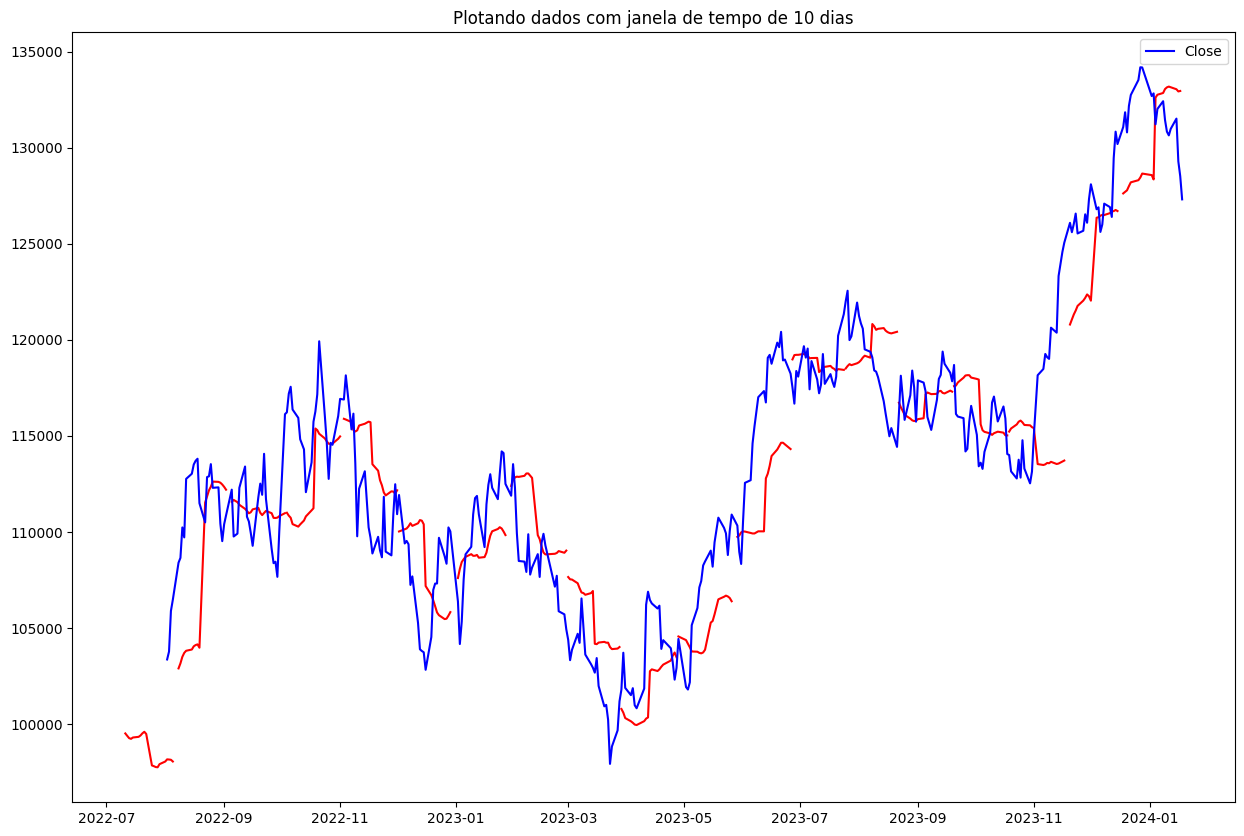

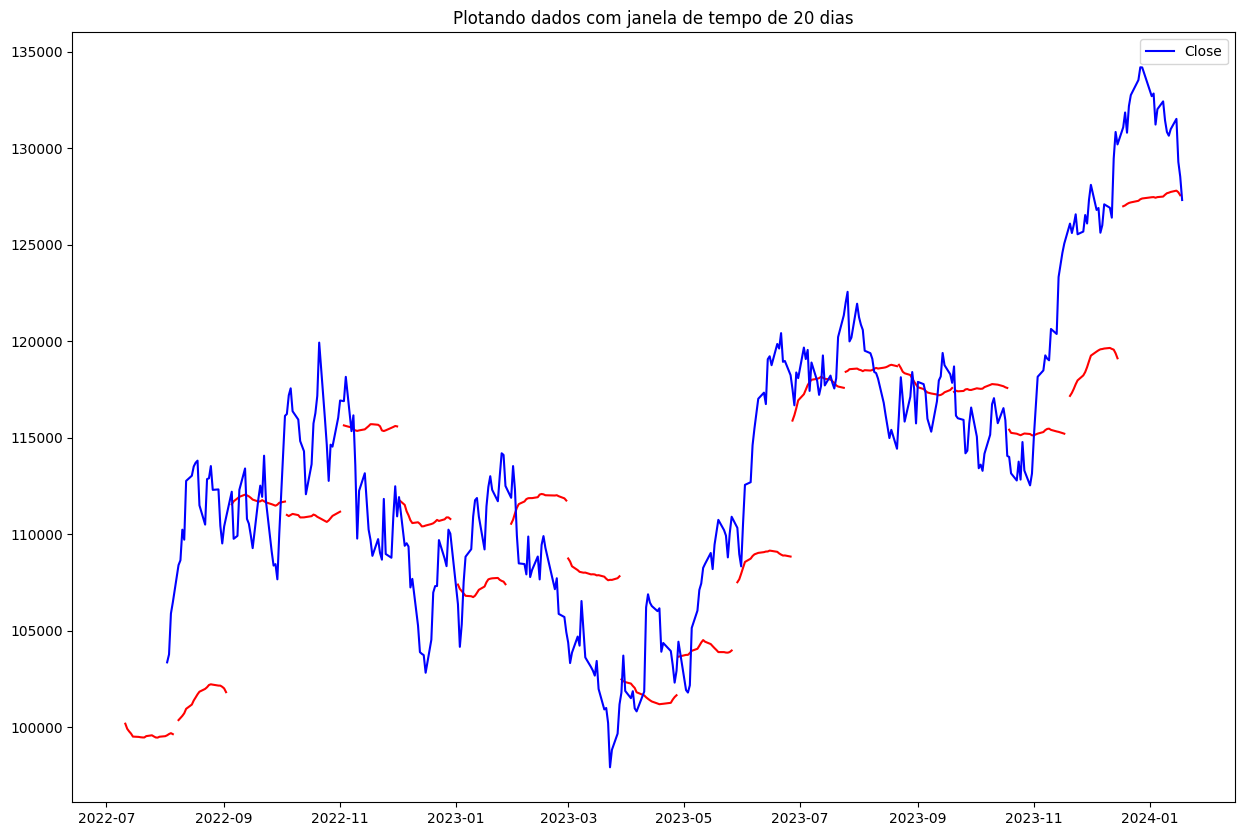

In [640]:
#Plotando dados com janela de 10 dias

plt.figure(figsize = (15,10))

size = len(df)-limit - (len(df)-limit)%forward_days

for index in range(size, len(df), forward_days):
    plt.plot(df['MA_window_10_forward_10'][index:index+forward_days], color='r')

plt.plot(df['Close'][-limit:], color='b', label='Close')
plt.title(label = 'Plotando dados com janela de tempo de 10 dias')
plt.legend(loc='best')
plt.show()

#Plotando dados com janela de 20 dias

plt.figure(figsize = (15,10))

size = len(df)-limit - (len(df)-limit)%forward_days

for index in range(size, len(df), forward_days):
    plt.plot(df['MA_window_20_forward_20'][index:index+forward_days], color='r')

plt.plot(df['Close'][-limit:], color='b', label='Close')
plt.title(label = 'Plotando dados com janela de tempo de 20 dias')
plt.legend(loc='best')
plt.show()

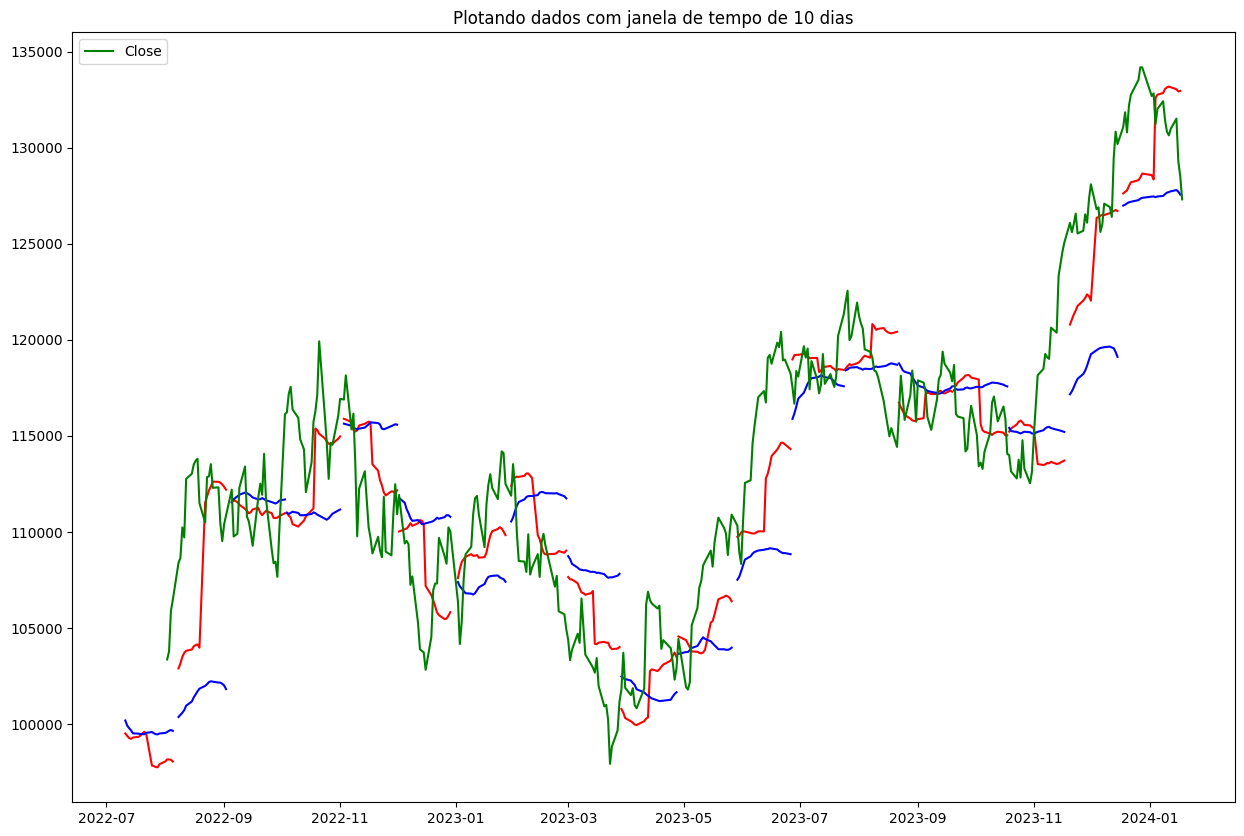

In [641]:
#Plotando dados com janela de 10 dias

plt.figure(figsize = (15,10))

size = len(df)-limit - (len(df)-limit)%forward_days

for index in range(size, len(df), forward_days):
    plt.plot(df['MA_window_10_forward_10'][index:index+forward_days], color='r')

for index in range(size, len(df), forward_days):
    plt.plot(df['MA_window_20_forward_20'][index:index+forward_days], color='b')


plt.plot(df['Close'][-limit:], color='g', label='Close')
plt.title(label = 'Plotando dados com janela de tempo de 10 dias')
plt.legend(loc=2)
plt.show()

#### 02.1.2 - Módelo ARIMA E SARIMA

#### 02.1.2.1 - ARIMA

##### Teste de Dickey-Fuller - Verificando a Estacionariedade da Série

In [642]:
# Teste de estacionariedade (ADF Test)

adf_result = adfuller(df_limpo['Close'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1].astype(int)}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

# Verificação se a série é estacionária
alpha = 0.05  # Limiar de significância
if adf_result[1] < alpha:
    print('A série é estacionária. Hipótese nula rejeitada.')
else:
    print('A série não é estacionária. Falha em rejeitar a hipótese nula.')

ADF Statistic: -1.3718784041905459
p-value: 0
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -1.3718784041905459
Valor-p: 0.5956812696445035
Valores Críticos:
   1%: -3.4332831704990503
   5%: -2.862835790766408
   10%: -2.5674598111615343
A série não é estacionária. Falha em rejeitar a hipótese nula.


##### Teste de Dickey-Fuller - Transformando a Série em estacionária

In [643]:
# Função para testar a estacionariedade da série transformada

def test_stationarity(timeseries):

    #Determinar estatísticas contínuas
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot estatísticas contínuas
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Performance do Dickey–Fuller:
    print('Results of Dickey Fuller Test:')
    adf_result = adfuller(timeseries['Close'], autolag='AIC')
    dfoutput = pd.Series(adf_result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in adf_result[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    alpha = 0.05  # Limiar de significância
    if adf_result[1] < alpha:
        print('A série é estacionária. Hipótese nula rejeitada.')
    else:
        print('A série não é estacionária. Falha em rejeitar a hipótese nula.')
        print(f'Valor-p: {adf_result[1]}')
        print(f'Limiar de Significância (alpha): {alpha}')


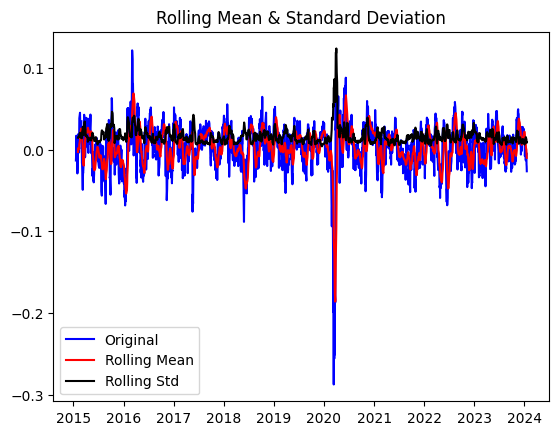

Results of Dickey Fuller Test:
Test Statistic                -1.163077e+01
p-value                        2.265430e-21
#Lags Used                     7.000000e+00
Number of Observations Used    2.222000e+03
Critical Value (1%)           -3.433296e+00
Critical Value (5%)           -2.862842e+00
Critical Value (10%)          -2.567463e+00
dtype: float64
A série é estacionária. Hipótese nula rejeitada.


In [644]:
# Log pela média móvel
indexedDataset_logScale = np.log(df_limpo) #Transformação logarítma

# Calculando a média móvel
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()

# Subtraindo os dados transformados pelo log menos a média móvel para remover o componente de tendência de ambos
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)

test_stationarity(datasetLogScaleMinusMovingAverage)

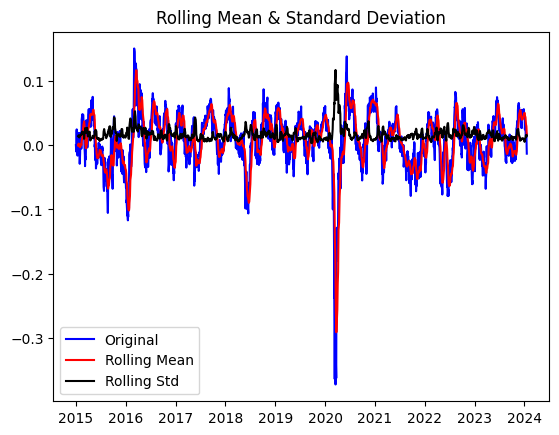

Results of Dickey Fuller Test:
Test Statistic                -7.471713e+00
p-value                        5.034605e-11
#Lags Used                     1.100000e+01
Number of Observations Used    2.229000e+03
Critical Value (1%)           -3.433287e+00
Critical Value (5%)           -2.862838e+00
Critical Value (10%)          -2.567461e+00
dtype: float64
A série é estacionária. Hipótese nula rejeitada.


In [645]:
# Decaimento Exponencial
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()

# Subtraindo o dataset em escala logarítma pelo decaimento exponencial
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)


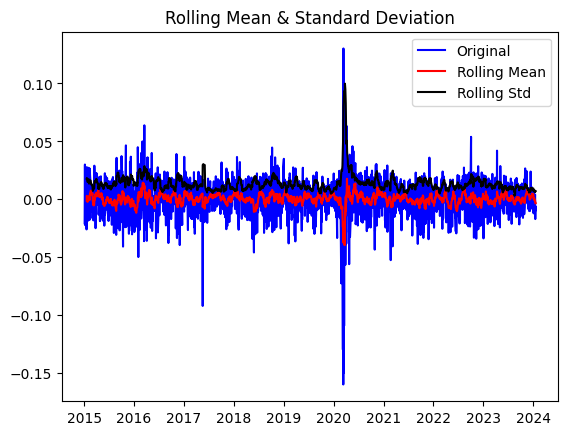

Results of Dickey Fuller Test:
Test Statistic                -1.695347e+01
p-value                        9.423434e-30
#Lags Used                     6.000000e+00
Number of Observations Used    2.233000e+03
Critical Value (1%)           -3.433282e+00
Critical Value (5%)           -2.862835e+00
Critical Value (10%)          -2.567460e+00
dtype: float64
A série é estacionária. Hipótese nula rejeitada.


In [646]:
# Diferenciação

datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift() #diferença entre o valor anterior e o atual
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)


##### Teste de correlação parcial

O ACF toca zero pela primeira vez no atraso 1.
O PACF toca zero pela primeira vez no atraso 1.


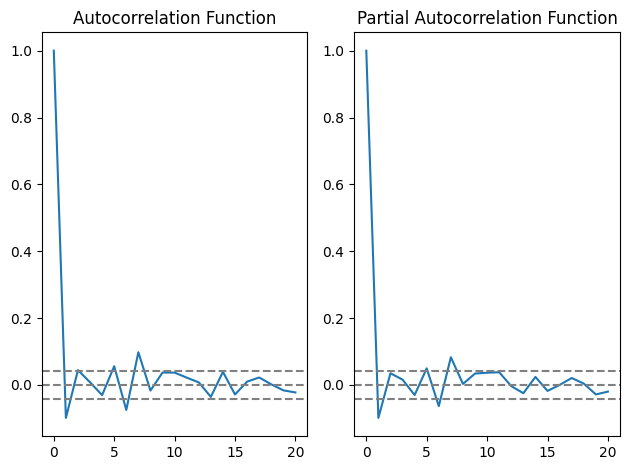

In [647]:
# Calcular ACF e PACF
lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

# Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Encontrar o primeiro ponto em que ACF toca zero
zero_crossing_acf = next(i for i, value in enumerate(lag_acf) if value <= 0)

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

# Encontrar o primeiro ponto em que PACF toca zero
zero_crossing_pacf = next(i for i, value in enumerate(lag_pacf) if value <= 0)

# Imprimir os resultados
print(f'O ACF toca zero pela primeira vez no atraso {zero_crossing_acf}.')
print(f'O PACF toca zero pela primeira vez no atraso {zero_crossing_pacf}.')

plt.tight_layout()
plt.show()

##### Plotando o Arima e Avaliando o MAPE (Mean Absolute Percentage Error)

Plotting AR model
RSS: 0.5549
MAPE: 1128.51%


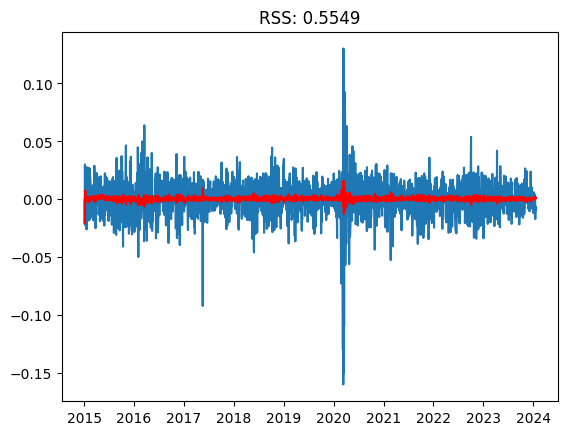

In [648]:
#AR Model
model = ARIMA(datasetLogDiffShifting, order=(1,1,1))#(p,d,q)
results_AR = model.fit()
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['Close'])**2))
print('Plotting AR model')
print('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['Close'])**2))


# Obtenha as previsões
predictions = results_AR.fittedvalues

# Ajuste os índices para garantir correspondência
predictions.index = datasetLogDiffShifting.index

# Inverta a diferenciação
# (indexedDataset_logScale['Close'].iloc[0]) para inverter a diferenciação.
# np.cumsum(predictions) é usado para calcular a soma cumulativa das previsões.
predicted_values = indexedDataset_logScale['Close'].iloc[0] + np.cumsum(predictions)

# Calcule o MAPE
mape = mean_absolute_error(datasetLogDiffShifting['Close'], predicted_values) * 100

print(f"MAPE: {mape:.2f}%")

#### 02.1.2.2 - SARIMA

O SARIMA, ou Seasonal AutoRegressive Integrated Moving Average, é uma extensão do modelo ARIMA para séries temporais que exibem sazonalidade. O acrônimo SARIMA representa "Seasonal ARIMA", indicando que o modelo incorpora componentes sazonais.

A estrutura do modelo SARIMA é definida por vários parâmetros, semelhantes ao ARIMA. A notação geral para um modelo SARIMA é SARIMA(p, d, q)(P, D, Q, s), onde:

p: Ordem AR (AutoRegressive) para a componente não sazonal.
d: Ordem de diferenciação para tornar a série temporal estacionária.
q: Ordem MA (Moving Average) para a componente não sazonal.
P: Ordem AR sazonal.
D: Ordem de diferenciação sazonal.
Q: Ordem MA sazonal.
s: Período sazonal.

##### Definindo parametros de Sazonalidade - P: Ordem AR sazonal.

In [649]:
# seasonal_lags = 30  # Ajuste conforme necessário

# # Calcule as linhas de confiança
# N = len(datasetLogDiffShifting)
# limite_superior = 1.96 / np.sqrt(N)
# limite_inferior = -1.96 / np.sqrt(N)

# # Calcule o ACF
# acf_values, _ = acf(datasetLogDiffShifting, fft=False, nlags=seasonal_lags, alpha=0.05)

# # Encontre os picos
# picos, _ = find_peaks(acf_values)

# # Identifique os picos fora da zona de significância
# picos_fora_da_zona = [pico for pico in picos if acf_values[pico] > limite_superior or acf_values[pico] < limite_inferior]

# # Visualize os resultados
# plot_acf(datasetLogDiffShifting, lags=seasonal_lags)
# plt.scatter(picos_fora_da_zona, acf_values[picos_fora_da_zona], color='red', marker='x', label='Picos fora da zona de significância')
# plt.axhline(y=limite_superior, linestyle='--', color='gray')
# plt.axhline(y=limite_inferior, linestyle='--', color='gray')
# plt.legend()
# plt.show()

# # Mostre quantos pontos estão fora da zona de significância
# print(f'Número de pontos fora da zona de significância: {len(picos_fora_da_zona)}')


Quando você encontra picos fora da zona de significância após a diferenciação dos dados, isso sugere que a diferenciação ajudou a tornar a série temporal mais estacionária. Vamos entender o que isso significa:

Dados Originais sem Diferenciação (Possivelmente Não Estacionários):

Se não há picos significativos fora da zona de significância no gráfico de autocorrelação (ACF) dos dados originais, isso pode indicar que a série temporal original não exibe padrões claros de autocorrelação nas observações. Isso pode ser um sinal de não estacionariedade ou de uma tendência que precisa ser removida.
Dados Diferenciados (Possivelmente Estacionários):

Quando você diferencia os dados e encontra picos fora da zona de significância, isso sugere que a diferenciação ajudou a remover a tendência ou padrões não estacionários, tornando a série temporal mais estacionária. Picos significativos no ACF podem indicar presença de autocorrelação sazonal ou não sazonal.

##### Definindo parametros de Sazonalidade - D: Ordem de diferenciação sazonal.

Escolha a Ordem de Diferenciação Sazonal Adequada:

Observe os gráficos ACF e PACF para diferentes ordens de D. A ordem de diferenciação sazonal adequada geralmente é aquela que reduz as autocorrelações sazonais mais significativamente e não deixa padrões aparentes.

Escolha a ordem de D que resulta em uma série temporal diferenciada sazonalmente mais estacionária, indicada por uma redução nas correlações significativas.

A interpretação dos gráficos ACF e PACF é fundamental, e você pode experimentar com diferentes ordens de D até encontrar uma que pareça apropriada.

In [650]:
# seasonal_lags = 30  # Ajuste conforme necessário


# # Plote ACF e PACF para diferentes ordens de diferenciação sazonal
# for D in range(1, 6):  # Teste ordens de 1 a 5, por exemplo
#     diff_series = datasetLogDiffShifting.diff(D * seasonal_lags).dropna()

#     # Plote ACF e PACF e obtenha os valores do ACF e PACF
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
#     plot_acf(diff_series, lags=seasonal_lags, ax=ax1)
#     plot_pacf(diff_series, lags=seasonal_lags, ax=ax2)
#     ax1.set_title(f'Ordem de Diferenciação Sazonal (D): {D} - ACF')
#     ax2.set_title(f'Ordem de Diferenciação Sazonal (D): {D} - PACF')

#     # Calcule os picos e limites de significância para ACF
#     acf_values = np.squeeze(ax1.lines[1].get_ydata())  # Obtenha os valores do ACF
#     picos_acf, _ = find_peaks(acf_values)
#     limite_superior_acf = 1.96 / np.sqrt(len(diff_series))
#     limite_inferior_acf = -1.96 / np.sqrt(len(diff_series))

#     # Plote os picos fora da zona de significância para ACF
#     ax1.scatter(picos_acf, acf_values[picos_acf], color='red', marker='x', label='Picos fora da zona de significância')
#     ax1.axhline(y=limite_superior_acf, linestyle='--', color='gray')
#     ax1.axhline(y=limite_inferior_acf, linestyle='--', color='gray')
#     ax1.legend()

#     # Calcule os picos e limites de significância para PACF
#     pacf_values = np.squeeze(ax2.lines[1].get_ydata())  # Obtenha os valores do PACF
#     picos_pacf, _ = find_peaks(pacf_values)
#     limite_superior_pacf = 1.96 / np.sqrt(len(diff_series))
#     limite_inferior_pacf = -1.96 / np.sqrt(len(diff_series))

#     # Plote os picos fora da zona de significância para PACF
#     ax2.scatter(picos_pacf, pacf_values[picos_pacf], color='red', marker='x', label='Picos fora da zona de significância')
#     ax2.axhline(y=limite_superior_pacf, linestyle='--', color='gray')
#     ax2.axhline(y=limite_inferior_pacf, linestyle='--', color='gray')
#     ax2.legend()

#     # Mostre quantos pontos estão fora da zona de significância para ACF e PACF
#     pontos_fora_zona_acf = len(picos_acf)
#     pontos_fora_zona_pacf = len(picos_pacf)
#     print(f'Ordem de Diferenciação Sazonal (D): {D}, Pontos fora da zona de significância (ACF): {pontos_fora_zona_acf}')
#     print(f'Ordem de Diferenciação Sazonal (D): {D}, Pontos fora da zona de significância (PACF): {pontos_fora_zona_pacf}')

#     plt.show()

Ordem de Diferenciação Sazonal (D): 4: Isso significa que a série temporal foi diferenciada quatro vezes com um lag sazonal para torná-la estacionária.

Pontos fora da zona de significância (ACF): 10: No gráfico de Autocorrelação (ACF), foram identificados 10 lags que têm autocorrelação significativamente diferente de zero. Isso pode indicar a presença de padrões sazonais na série temporal.

Pontos fora da zona de significância (PACF): 10: No gráfico de Autocorrelação Parcial (PACF), também foram identificados 10 lags que têm autocorrelação parcial significativamente diferente de zero. Esses pontos indicam lags em que há uma correlação que não é explicada pelas correlações nos lags anteriores, sugerindo possível influência sazonal.

##### Definindo parametros de Sazonalidade - Q: Ordem MA sazonal.

Este parâmetro indica o número de lags no qual os erros de previsão são correlacionados sazonalmente. Em outras palavras, refere-se à quantidade de termos de média móvel que estão incluídos no modelo para explicar padrões sazonais

Escolhendo o melhor Q:

Escolher o valor adequado para a ordem MA sazonal (Q) envolve analisar os gráficos ACF (Função de Autocorrelação) e observar os pontos fora da zona de significância. Aqui estão algumas diretrizes que podem ajudar:

Identificar o Lag Sazonal: Observe se há lags sazonais significativos no gráfico ACF. Esses lags representam a sazonalidade na série temporal. A ordem MA sazonal (Q) deve ser escolhida com base na quantidade de lags significativos.

Número Mínimo de Lags Sazonais: Comece testando com um número pequeno de lags sazonais e observe como a autocorrelação se comporta. Aumente gradualmente o valor de Q e observe se há melhora na explicação da sazonalidade.

Evite Overfitting: Evite escolher um valor muito alto para Q, pois isso pode levar a um overfitting, onde o modelo se ajusta demais aos dados de treinamento e não generaliza bem para novos dados.

Validação Cruzada: Considere o uso de técnicas de validação cruzada, como dividir seus dados em conjuntos de treinamento e teste, para avaliar o desempenho do modelo com diferentes valores de Q.

Modelagem Iterativa: A escolha do valor adequado para Q muitas vezes é um processo iterativo. Você pode testar diferentes valores, ajustar o modelo e avaliar o desempenho até encontrar uma configuração que forneça bons resultados.

In [651]:
# seasonal_lags = 30  # Ajuste conforme necessário

# # Plote ACF para diferentes ordens MA sazonal (Q)
# for Q in range(1, 6):  # Teste ordens de 1 a 5, por exemplo
#     diff_series = datasetLogDiffShifting['Close'].diff(seasonal_lags).dropna()
#     # Plote ACF e obtenha os valores do ACF
#     fig, ax = plt.subplots(figsize=(10, 4))
#     plot_acf(diff_series, lags=Q * seasonal_lags, ax=ax)
#     ax.set_title(f'Ordem MA Sazonal (Q): {Q}')

#     # Calcule os picos e limites de significância
#     acf_values = np.squeeze(ax.lines[1].get_ydata())  # Obtenha os valores do ACF
#     picos, _ = find_peaks(acf_values)
#     limite_superior = 1.96 / np.sqrt(len(diff_series))
#     limite_inferior = -1.96 / np.sqrt(len(diff_series))

#     # Plote os picos fora da zona de significância
#     ax.scatter(picos, acf_values[picos], color='red', marker='x', label='Picos fora da zona de significância')
#     ax.axhline(y=limite_superior, linestyle='--', color='gray')
#     ax.axhline(y=limite_inferior, linestyle='--', color='gray')
#     ax.legend()

#     # Mostre quantos pontos estão fora da zona de significância
#     pontos_fora_zona = len(picos)
#     print(f'Ordem MA Sazonal (Q): {Q}, Pontos fora da zona de significância: {pontos_fora_zona}')

#     plt.show()

In [652]:
# # Ajuste o modelo SARIMA
# order = (1, 1, 1)  # Ordem (p, d, q) para a parte não sazonal
# seasonal_order = (1, 2, 2, 30)  # Ordem (P, D, Q, s) para a parte sazonal
# model = SARIMAX(datasetLogDiffShifting['Close'], order=order, seasonal_order=seasonal_order)
# results = model.fit()

# # Faça previsões passo a passo
# forecast_steps = 30
# for i in range(forecast_steps):
#     forecast = results.get_forecast(steps=1)

# # Obtenha os valores previstos e os intervalos de confiança
# forecast_values = forecast.predicted_mean
# confidence_intervals = forecast.conf_int()

# # Visualize os resultados
# plt.plot(datasetLogDiffShifting['Close'], label='Observações')
# plt.plot(forecast_values, label='Previsões', color='red')
# plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='red', alpha=0.2)
# plt.legend()
# plt.show()

In [653]:
# import pandas as pd
# import numpy as np
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# import matplotlib.pyplot as plt

# # Suponha que você tenha um DataFrame chamado datasetLogDiffShifting com uma coluna 'Close'
# # Certifique-se de que datasetLogDiffShifting['Close'] seja uma série temporal com índice de datas

# # Ajustar o intervalo de datas conforme necessário
# start_date = '2023-01-01'
# end_date = '2023-12-31'
# datasetLogDiffShifting = datasetLogDiffShifting[start_date:end_date]

# # Configurar o modelo SARIMAX
# order = (1, 1, 1)  # Ordem (p, d, q) para a parte não sazonal
# seasonal_order = (1, 2, 2, 30)  # Ordem (P, D, Q, s) para a parte sazonal
# model = SARIMAX(datasetLogDiffShifting['Close'], order=order, seasonal_order=seasonal_order)
# results = model.fit()

# # Fazer previsões
# forecast_steps = 365  # Número de passos à frente para prever (um ano, por exemplo)
# forecast = results.get_forecast(steps=forecast_steps)

# # Obter os valores previstos
# forecast_values = forecast.predicted_mean

# # Visualizar os resultados apenas para o intervalo específico
# # Visualizar os resultados apenas para o intervalo específico
# plt.figure(figsize=(10, 6))
# plt.plot(datasetLogDiffShifting['Close'], label='Observado', color='blue')
# plt.plot(forecast_values.index, forecast_values.values, label='Previsão', color='red')
# plt.fill_between(forecast_values.index,
#                  forecast.conf_int().iloc[:, 0],
#                  forecast.conf_int().iloc[:, 1], color='red', alpha=0.2)

# plt.title('Previsão usando SARIMAX - Intervalo Específico')
# plt.xlabel('Data')
# plt.ylabel('Valores')
# plt.legend()
# plt.show()

#### 02.2 - Trabalhando com Previsões (Prophet e LSTM)

#### 02.2.1 - PROPHET

In [654]:
# Importando os dados do IBOVESP para o modelo

symbol = '^BVSP'
start_date = '2015-01-01'
end_date = '2024-01-19'

# Use a função download para obter os dados
df = yf.download(symbol, start=start_date, end=end_date)
df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date'])
df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)
df[['ds', 'y']] = df[['Date', 'Close']]
df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Close,ds,y
0,2015-01-02,48512.0,2015-01-02,48512.0
1,2015-01-05,47517.0,2015-01-05,47517.0
2,2015-01-06,48001.0,2015-01-06,48001.0
3,2015-01-07,49463.0,2015-01-07,49463.0
4,2015-01-08,49943.0,2015-01-08,49943.0


#### 02.2.1.1 - Separando os dados em treino e teste

In [655]:
train_data = df.sample(frac=0.75, random_state=23)
test_data = df.drop(train_data.index)
print(f'Volume de dados de treino: {train_data.shape}')
print(f'Volume de dados de teste: {test_data.shape}')

Volume de dados de treino: (1681, 4)
Volume de dados de teste: (560, 4)


In [656]:
pptModel = Prophet(daily_seasonality=True)
pptModel.fit(train_data)
dataFramefuture = pptModel.make_future_dataframe(periods=20, freq='M')
previsao = pptModel.predict(dataFramefuture)
previsao.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-02,48783.813208,45631.991666,61466.050410,48783.813208,48783.813208,5089.566818,5089.566818,5089.566818,2655.581169,...,223.917521,223.917521,223.917521,2210.068128,2210.068128,2210.068128,0.0,0.0,0.0,53873.380026
1,2015-01-05,48751.721828,45968.298555,61253.890456,48751.721828,48751.721828,4866.715725,4866.715725,4866.715725,2655.581169,...,-74.348805,-74.348805,-74.348805,2285.483361,2285.483361,2285.483361,0.0,0.0,0.0,53618.437554
2,2015-01-06,48741.024702,45843.617681,61625.127882,48741.024702,48741.024702,5237.268373,5237.268373,5237.268373,2655.581169,...,271.600487,271.600487,271.600487,2310.086717,2310.086717,2310.086717,0.0,0.0,0.0,53978.293074
3,2015-01-07,48730.327575,46085.802242,61970.176013,48730.327575,48730.327575,5080.584454,5080.584454,5080.584454,2655.581169,...,89.555696,89.555696,89.555696,2335.447588,2335.447588,2335.447588,0.0,0.0,0.0,53810.912029
4,2015-01-12,48676.841942,46152.776414,61971.437899,48676.841942,48676.841942,5066.875375,5066.875375,5066.875375,2655.581169,...,-74.348805,-74.348805,-74.348805,2485.643011,2485.643011,2485.643011,0.0,0.0,0.0,53743.717317


A Biblioteca de retorno da previsão é:

ds (Carimbo de data): Esta coluna representa as datas para as quais as previsões estão sendo feitas.

trend (Tendência): É a estimativa da tendência geral nos dados.

yhat_lower e yhat_upper: Esses são os limites inferior e superior dos valores previstos (yhat). O modelo fornece uma estimativa intervalar para as previsões.

trend_lower e trend_upper: Esses são os limites inferior e superior para a tendência geral.

additive_terms, additive_terms_lower, additive_terms_upper: Representam componentes adicionais adicionados à tendência, incluindo sazonalidades diárias, semanais, anuais e outras especificadas.

daily (Diário): O componente de sazonalidade diária.

weekly (Semanal): O componente de sazonalidade semanal.

yearly (Anual): O componente de sazonalidade anual.

multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper: Representam componentes multiplicativos, mas, no seu caso, parecem ser todos zeros, indicando que não há termos multiplicativos.

yhat: Este é o valor previsto (previsão) para cada data.

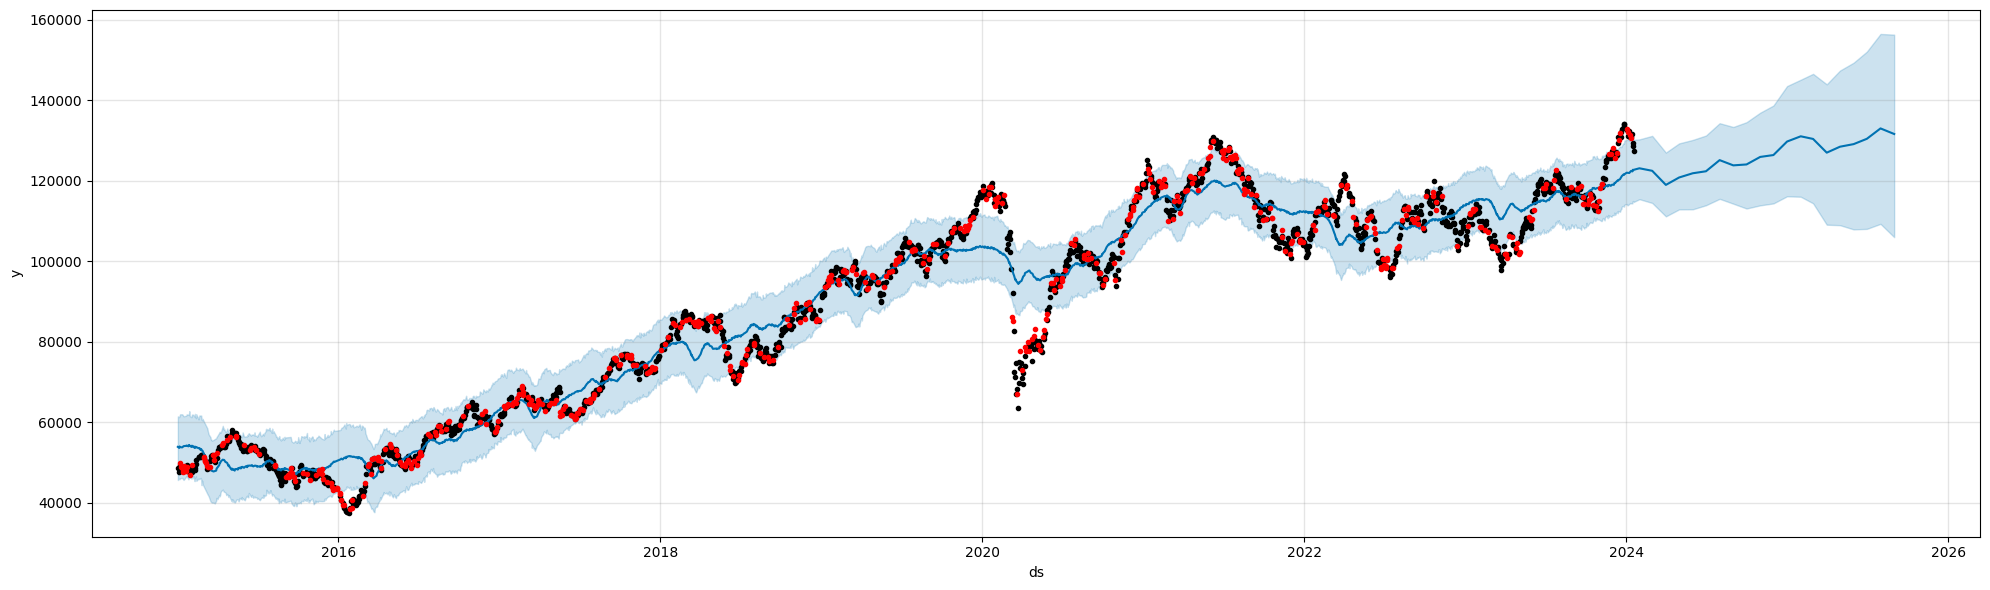

In [657]:
pptModel.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

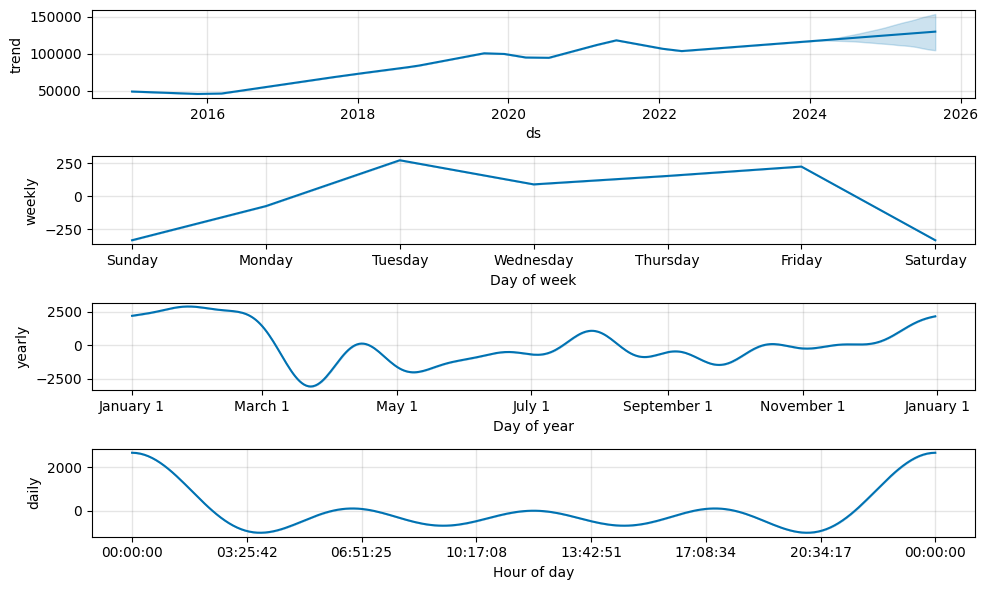

In [658]:
pptModel.plot_components(previsao, figsize=(10,6));

#### 02.2.1.2 - PROPHET - Avaliando o modelo

Avaliando os resultados do Prophet

In [659]:
pptModel = Prophet(daily_seasonality=True)
pptModel.fit(train_data)
dataFramefuture = pptModel.make_future_dataframe(periods=20, freq='M')
previsao = pptModel.predict(dataFramefuture)

valores_reais_cols = ['ds', 'y']
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
previsao = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o MSE e RMSE
mse = mean_squared_error(previsao['y'], previsao['yhat'])
rmse = np.sqrt(mse)

# Calcular o MAE
mae = mean_absolute_error(previsao['y'], previsao['yhat'])

# Calcular o MAPE
mape = np.mean(np.abs((previsao['y'] - previsao['yhat']) / previsao['y'])) * 100

# Calcular o MdAPE
mdape = np.median(np.abs((previsao['y'] - previsao['yhat']) / previsao['y'])) * 100

# SMAPE precisa de um tratamento especial se houver valores zero em 'y'
smape = 2 * np.mean(np.abs(previsao['y'] - previsao['yhat']) / (np.abs(previsao['y']) + np.abs(previsao['yhat']))) * 100

# Calcular a cobertura (coverage)
coverage = np.mean((previsao['y'] >= previsao['yhat_lower']) & (previsao['y'] <= previsao['yhat_upper'])) * 100

# Imprimir os previsao
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'MdAPE: {mdape}')
print(f'SMAPE: {smape}')
print(f'Coverage: {coverage}')

MSE: 37019872.42578592
RMSE: 6084.395814358721
MAE: 4578.845604947323
MAPE: 5.56366831865925
MdAPE: 4.265284314395944
SMAPE: 5.451662501165019
Coverage: 82.8078524687686


Utilizando o Cross_Validation no comparativo

In [660]:
df_cv = cross_validation(pptModel, initial='730 days', period='180 days', horizon = '365 days')

# Calcular o MSE e RMSE
mse = mean_squared_error(df_cv['y'], df_cv['yhat'])
rmse = np.sqrt(mse)

# Calcular o MAE
mae = mean_absolute_error(df_cv['y'], df_cv['yhat'])

# Calcular o MAPE
mape = np.mean(np.abs((df_cv['y'] - df_cv['yhat']) / df_cv['y'])) * 100

# Calcular o MdAPE
mdape = np.median(np.abs((df_cv['y'] - df_cv['yhat']) / df_cv['y'])) * 100

# SMAPE precisa de um tratamento especial se houver valores zero em 'y'
smape = 2 * np.mean(np.abs(df_cv['y'] - df_cv['yhat']) / (np.abs(df_cv['y']) + np.abs(df_cv['yhat']))) * 100

# Calcular a cobertura (coverage)
coverage = np.mean((df_cv['y'] >= df_cv['yhat_lower']) & (df_cv['y'] <= df_cv['yhat_upper'])) * 100

# Imprimir os resultados
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')
print(f'MdAPE: {mdape}')
print(f'SMAPE: {smape}')
print(f'Coverage: {coverage}')



  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:05<00:00,  2.42it/s]

MSE: 424663591.90712327
RMSE: 20607.367418161964
MAE: 16587.11230409021
MAPE: 17.25731332375344
MdAPE: 14.62287688888248
SMAPE: 16.286992049226026
Coverage: 29.21997523730912


**Sem Cross Validation:**
- **MSE (Erro Quadrático Médio):** 31602033.60
- **RMSE (Raiz do Erro Quadrático Médio):** 5621.57
- **MAE (Erro Absoluto Médio):** 3768.76
- **MAPE (Erro Percentual Absoluto Médio):** 7.02%
- **MdAPE (Erro Percentual Absoluto Mediano):** 5.42%
- **SMAPE (Erro Percentual Absoluto Médio Simétrico):** 6.86%
- **Coverage (Cobertura):** 85.37%

**Com Cross Validation:**
- **MSE (Erro Quadrático Médio):** 176245905.23
- **RMSE (Raiz do Erro Quadrático Médio):** 13275.76
- **MAE (Erro Absoluto Médio):** 9909.55
- **MAPE (Erro Percentual Absoluto Médio):** 17.75%
- **MdAPE (Erro Percentual Absoluto Mediano):** 13.01%
- **SMAPE (Erro Percentual Absoluto Médio Simétrico):** 17.73%
- **Coverage (Cobertura):** 29.45%

**Análise:**
- **Sem Cross Validation:** O modelo parece ter um desempenho relativamente bom com métricas como MSE, RMSE e MAE. A cobertura (Coverage) de 85.37% sugere que os intervalos de previsão capturaram adequadamente os valores reais na maioria das previsões.
  
- **Com Cross Validation:** As métricas indicam um aumento significativo nos erros, com RMSE e MAPE notavelmente mais altos. A cobertura (Coverage) de 29.45% sugere que os intervalos de previsão têm uma capacidade limitada de capturar os valores reais, indicando uma possível subestimação da incerteza.

**Considerações:**
- O aumento nas métricas com validação cruzada pode indicar que o modelo pode estar superajustado (overfitting) aos dados de treinamento, resultando em uma capacidade limitada de generalização para novos dados.
  


#### 02.2.2 - LSTM

In [685]:
# Importando os dados do IBOVESP para o modelo

symbol = '^BVSP'
start_date = '2019-01-01'
end_date = '2024-01-19'

# Use a função download para obter os dados
df = yf.download(symbol, start=start_date, end=end_date)
df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date'])
df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)
close_data = df['Close'].values
close_data = close_data.reshape(-1,1) #transformar em array

# Normalizando os Dados

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

[*********************100%%**********************]  1 of 1 completed


#### 02.2.2.1 - Separando os dados em treino e teste

In [686]:
split_percent = 0.75
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

940
314


In [687]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 10

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [688]:
np.random.seed(23)

lstm_model = Sequential()
lstm_model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
lstm_model.add(Dense(1)),

lstm_model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

num_epochs = 20
lstm_model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/20


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1783 - mean_squared_error: 0.1788
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 - mean_squared_error: 0.0043
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017   
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - mean_squared_error: 0.0012
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022   
Epoch 9/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 10/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - mean_squared_error: 0.0013   
Epoch 11/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.

In [689]:
# Avaliando o modelo nos dados de teste
mse = lstm_model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio", mse[0])

# 1. Fazer previsões usando o conjunto de teste
test_predictions = lstm_model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f'MAPE: {mape:.4f}')

#O RMSE é a raiz quadrada do MSE (Mean Squared Error), que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])

print("RMSE:", rmse_value)

304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.0021e-04 - mean_squared_error: 8.0021e-04
Erro Quadrático Médio 0.0006907437345944345
304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAPE: 2.2644
RMSE: 0.026282004006438216


In [690]:
prediction = lstm_model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições da IBOVESPA",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

304/304 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


#### 02.2.2.2 - Validando a Série Temporal com Suavização

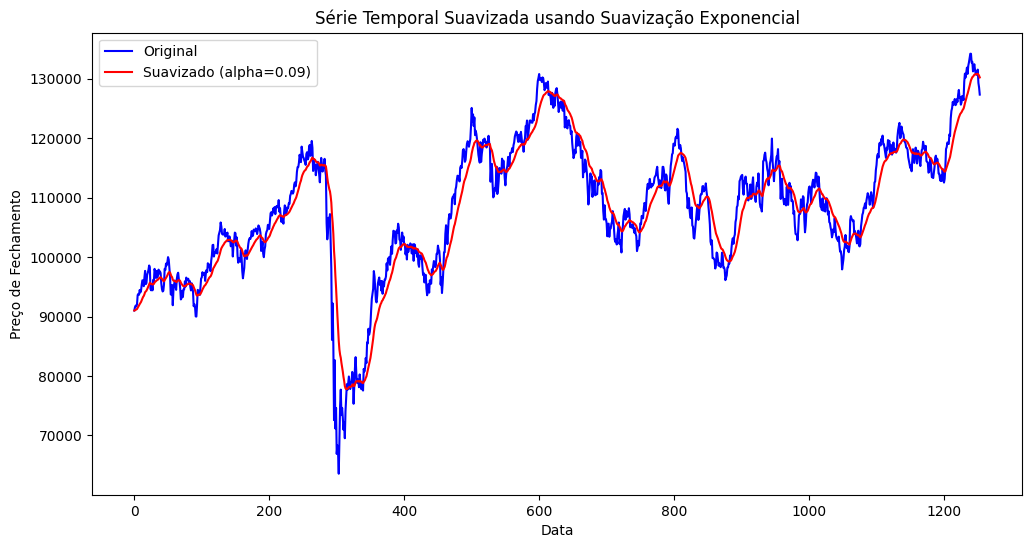

In [691]:
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime

# Suazivando a série temporal
# Aplicando suavização exponencial
alpha = 0.09   # Fator de suavização
# O parâmetro alpha na suavização exponencial controla a taxa de decaimento dos pesos atribuídos às observações passadas.
# Determina o quão rapidamente o impacto das observações antigas diminui à medida que você avança no tempo.

df['Smoothed_Close'] = df['Close'].ewm(alpha=alpha, adjust=False).mean()

# Visualizando os resultados
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Original', color='blue')
plt.plot(df.index, df['Smoothed_Close'], label=f'Suavizado (alpha={alpha})', color='red')
plt.title('Série Temporal Suavizada usando Suavização Exponencial')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()

In [692]:
# Teste de estacionariedade (ADF Test)
adf_result = adfuller(df['Smoothed_Close'] )
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')
alpha = 0.05  # Limiar de significância
if adf_result[1] < alpha:
    print('A série é estacionária. Hipótese nula rejeitada.')
else:
    print('A série não é estacionária. Falha em rejeitar a hipótese nula.')
    print(f'Valor-p: {adf_result[1]}')
    print(f'Limiar de Significância (alpha): {alpha}')


ADF Statistic: -3.0744740303015115
p-value: 0.02850080728018639
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -3.0744740303015115
Valor-p: 0.02850080728018639
Valores Críticos:
   1%: -3.4356133204636095
   5%: -2.8638642784217305
   10%: -2.5680074748794373
A série é estacionária. Hipótese nula rejeitada.


In [693]:
df.drop(columns=['Close'], inplace=True)
df.head()

,Date,Smoothed_Close
0,2019-01-02,91012.000000
1,2019-01-03,91061.680000
2,2019-01-04,91131.818800
3,2019-01-07,91182.865108
4,2019-01-08,91259.287248


In [694]:
close_data = df['Smoothed_Close'].values
close_data = close_data.reshape(-1,1) #transformar em array

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

1003
251


In [695]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 5

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=[MeanSquaredError()])

num_epochs = 100
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/100


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1451 - mean_squared_error: 0.1450   
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0049 - mean_squared_error: 0.0050
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - mean_squared_error: 0.0013     
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mean_squared_error: 0.0014     
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.6365e-04 - mean_squared_error: 9.6519e-04
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4830e-04 - mean_squared_error: 4.4841e-04
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010 - mean_squared_error: 0.0010     
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3729e-04 - mean_squared_error: 5.3791e-04
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1408e-04 - mean_squared_error: 6.1409e-04
Epoch 11/10

In [696]:
# 1. Fazer previsões usando o conjunto de teste
test_predictions = model.predict(test_generator)

# 2. Inverter qualquer transformação aplicada aos dados
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_actuals_inv = scaler.inverse_transform(np.array(close_test).reshape(-1, 1))

# Ajuste as dimensões
test_actuals_inv = test_actuals_inv[:len(test_predictions_inv)]

# Calcular o MAPE
mape = np.mean(np.abs((test_actuals_inv - test_predictions_inv) / test_actuals_inv)) * 100

# Imprimir o MAPE
print(f"MAPE: {mape:.2f}%"),

# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio:", mse[0])

# O RMSE é a raiz quadrada do MSE (Mean Squared Error), que é a média dos quadrados das diferenças entre as previsões do modelo e os valores reais.
rmse_value = np.sqrt(mse[0])
print("RMSE:", rmse_value)


246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MAPE: 0.65%
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7604e-04 - mean_squared_error: 1.7604e-04
Erro Quadrático Médio: 0.00029688331414945424
RMSE: 0.01723030220714234


In [697]:
prediction = model.predict(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Predições da IBOVESPA",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

  1/246 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


#### 02.2.2.3 - Realizando o Forecasting

In [698]:
close_data = close_data.reshape((-1))

# Função para prever os próximos 'num_prediction' pontos da série temporal
# Utiliza o modelo treinado para prever cada ponto sequencialmente
# A cada iteração, adiciona a previsão à lista 'prediction_list'

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]

    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]

    return prediction_list

# Função para gerar as datas dos próximos 'num_prediction' dias
# Assume que o DataFrame 'df' possui uma coluna 'Date' contendo as datas

def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 15 #definição dos próximos dias
forecast = predict(num_prediction, model) #resultado de novos dias
forecast_dates = predict_dates(num_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [699]:
trace1 = go.Scatter(
    x = date_test,
    y = close_test,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = forecast_dates,
    y = forecast,
    mode = 'lines',
    name = 'Prediction'
)
layout = go.Layout(
    title = "Forecast IBOVESP",
    xaxis = {'title' : "Data"},
    yaxis = {'title' : "Fechamento"}
)
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

#### 02.2.2.4 - Organizando os Dados em um Dataframe

In [700]:
df_ltsm_suav = pd.DataFrame(df)
df_past = df_ltsm_suav[['Date','Smoothed_Close']]
df_past.rename(columns={'Smoothed_Close': 'Actual'}, inplace=True)         #criando nome das colunas
df_past['Date'] = pd.to_datetime(df_past['Date'])                          #configurando para datatime
df_past['Forecast'] = np.nan                                               #Preenchendo com NAs
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

# Faz a transformação inversa das predições
forecast = forecast.reshape(-1, 1) #reshape para array
forecast = scaler.inverse_transform(forecast)

df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = forecast_dates
df_future['Forecast'] = forecast.flatten()
df_future['Actual'] = np.nan

# Concatenando os DataFrames usando concat
frames = [df_past, df_future]
results = pd.concat(frames, ignore_index=True).set_index('Date')

results2023 =  results.loc['2023-01-01':]

plot_data = [
    go.Scatter(
        x=results2023.index,
        y=results2023['Actual'],
        name='actual'
    ),
    go.Scatter(
        x=results2023.index,
        y=results2023['Forecast'],
        name='prediction'
    )
]

plot_layout = go.Layout(
        title='Forecast IBOVESP'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig.show()


In [735]:
# Importando os dados do IBOVESP para o modelo

symbol = '^BVSP'
start_date = '2019-01-01'
end_date = '2024-01-19'

# Use a função download para obter os dados
df_ltsm = yf.download(symbol, start=start_date, end=end_date)
df_ltsm = df_ltsm.reset_index('Date')
df_ltsm['Date'] = pd.to_datetime(df_ltsm['Date'])
df_ltsm.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)
df_past_ltsm = df_ltsm[['Date','Close']]

df_past_ltsm.rename(columns={'Close': 'Actual'}, inplace=True)
df_past_ltsm['Date'] = pd.to_datetime(df_past_ltsm['Date'])
df_past_ltsm['Forecast'] = np.nan
df_past_ltsm['Forecast'].iloc[-1] = df_past_ltsm['Actual'].iloc[-1]

df_future_ltsm = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future_ltsm['Date'] = forecast_dates
df_future_ltsm['Forecast'] = forecast.flatten()
# Concatenando os DataFrames usando concat
frames_ltsm = [df_past_ltsm, df_future_ltsm]
results_ltsm = pd.concat(frames_ltsm, ignore_index=True).set_index('Date')

results_ltsm2023 =  results_ltsm.loc['2023-01-01':]

plot_data = [
    go.Scatter(
        x=results_ltsm2023.index,
        y=results_ltsm2023['Actual'],
        name='actual'
    ),
    go.Scatter(
        x=results_ltsm2023.index,
        y=results_ltsm2023['Forecast'],
        name='prediction'
    )
]

plot_layout = go.Layout(
        title='Forecast IBOVESP'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)

fig.show()

[*********************100%%**********************]  1 of 1 completed
